# Evaluating Model Performance
We will evaluate and compare the performance of the models using the following metrics:
- Accuracy
- Precision
- Recall


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

In [2]:
os.chdir(r'C:\Users\david\projects\University\gemstone-classifier\src')

### Load the training results

In [3]:
results = {}
top_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Top-3 Accuracy', 'Top-5 Accuracy'])

for dataset in os.listdir('../mod/'):
    for file in os.listdir(f'../mod/{dataset}/'):
        if file.endswith('.csv'):
            model = os.path.splitext(file)[0]
            print(f'Processing {model}...')
            history = pd.read_csv(f'../mod/{dataset}/{file}')
            results[model] = history
            top_results = pd.concat([top_results, pd.DataFrame({'Model': model,
                                                                'Dataset': dataset,
                                                                'Accuracy': history['val_accuracy'].max(),
                                                                'Top-3 Accuracy': history['val_top_3_accuracy'].max(),
                                                                'Top-5 Accuracy': history['val_top_5_accuracy'].max()}, index=[0])])
top_results

Processing MobileNet...
Processing OwnModel...
Processing OwnModelRegularized...
Processing ResNet50...
Processing VGG16...


C:\Users\david\AppData\Local\Temp\ipykernel_11068\3948187483.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_results = pd.concat([top_results, pd.DataFrame({'Model': model,


,Model,Dataset,Accuracy,Top-3 Accuracy,Top-5 Accuracy
0,MobileNet,gempundit_2022_cropped_augmented_2000,0.453283,0.746328,0.829718
0,OwnModel,gempundit_2022_cropped_augmented_2000,0.505666,0.818385,0.892461
0,OwnModelRegularized,gempundit_2022_cropped_augmented_2000,0.535529,0.837886,0.904374
0,ResNet50,gempundit_2022_cropped_augmented_2000,0.305107,0.579304,0.701216
0,VGG16,gempundit_2022_cropped_augmented_2000,0.502675,0.819698,0.890272


### Plot the metrics for each model over the epochs

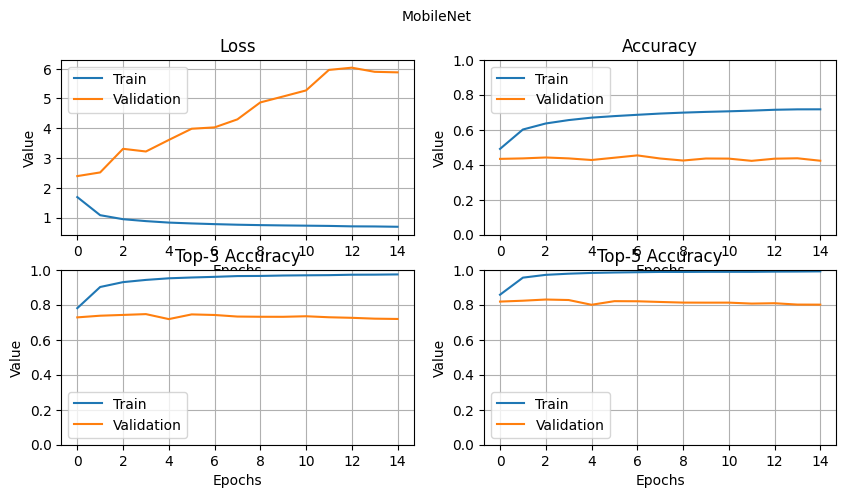

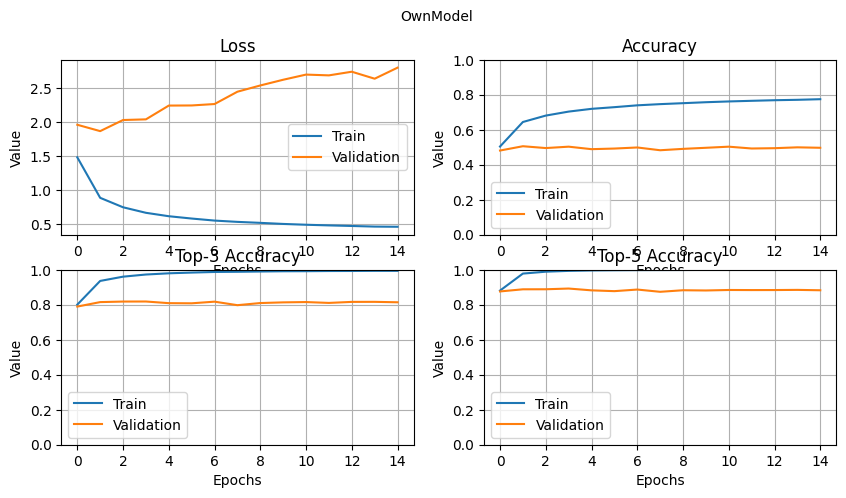

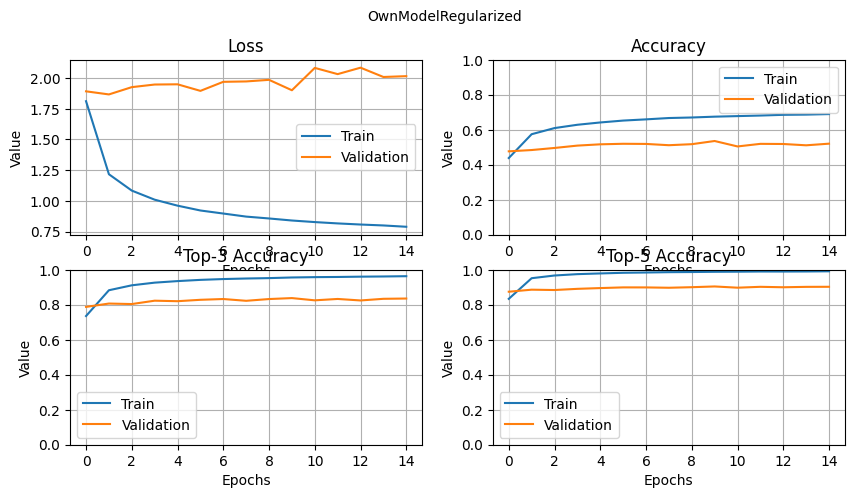

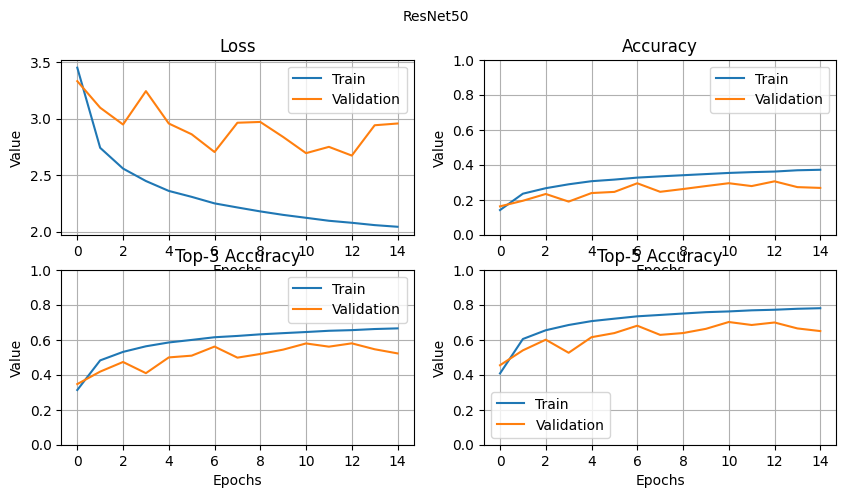

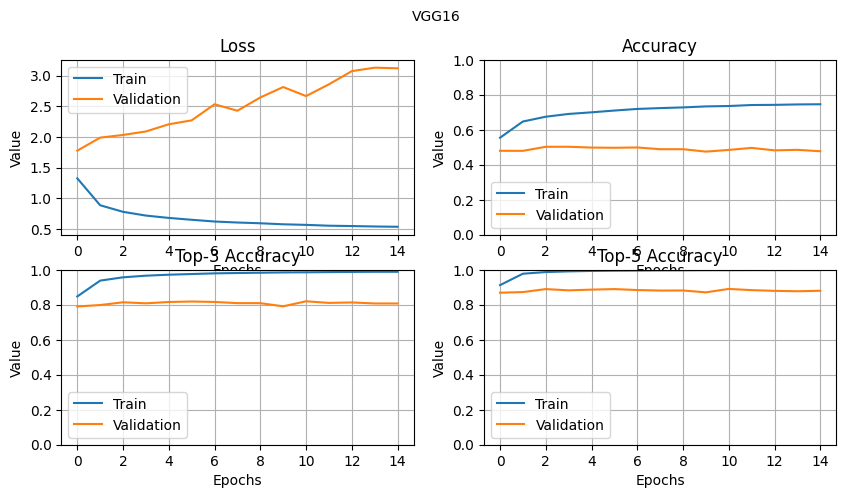

In [4]:
# Define a function to plot the metrics with adjusted y-axis limits for accuracy plots
def plot_metrics_adjusted(history, title):
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    fig.suptitle(title, fontsize=10)

    # Loss
    axs[0, 0].plot(history['loss'], label='Train')
    axs[0, 0].plot(history['val_loss'], label='Validation')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy
    axs[0, 1].plot(history['accuracy'], label='Train')
    axs[0, 1].plot(history['val_accuracy'], label='Validation')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_ylim([0, 1])
    axs[0, 1].legend()

    # Top-3 Accuracy
    axs[1, 0].plot(history['top_3_accuracy'], label='Train')
    axs[1, 0].plot(history['val_top_3_accuracy'], label='Validation')
    axs[1, 0].set_title('Top-3 Accuracy')
    axs[1, 0].set_ylim([0, 1])
    axs[1, 0].legend()

    # Top-5 Accuracy
    axs[1, 1].plot(history['top_5_accuracy'], label='Train')
    axs[1, 1].plot(history['val_top_5_accuracy'], label='Validation')
    axs[1, 1].set_title('Top-5 Accuracy')
    axs[1, 1].set_ylim([0, 1])
    axs[1, 1].legend()

    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Value')
        ax.grid()

for model, history in results.items():
    plot_metrics_adjusted(history, model)


### Compare the models for the used Top-K-Accuracy

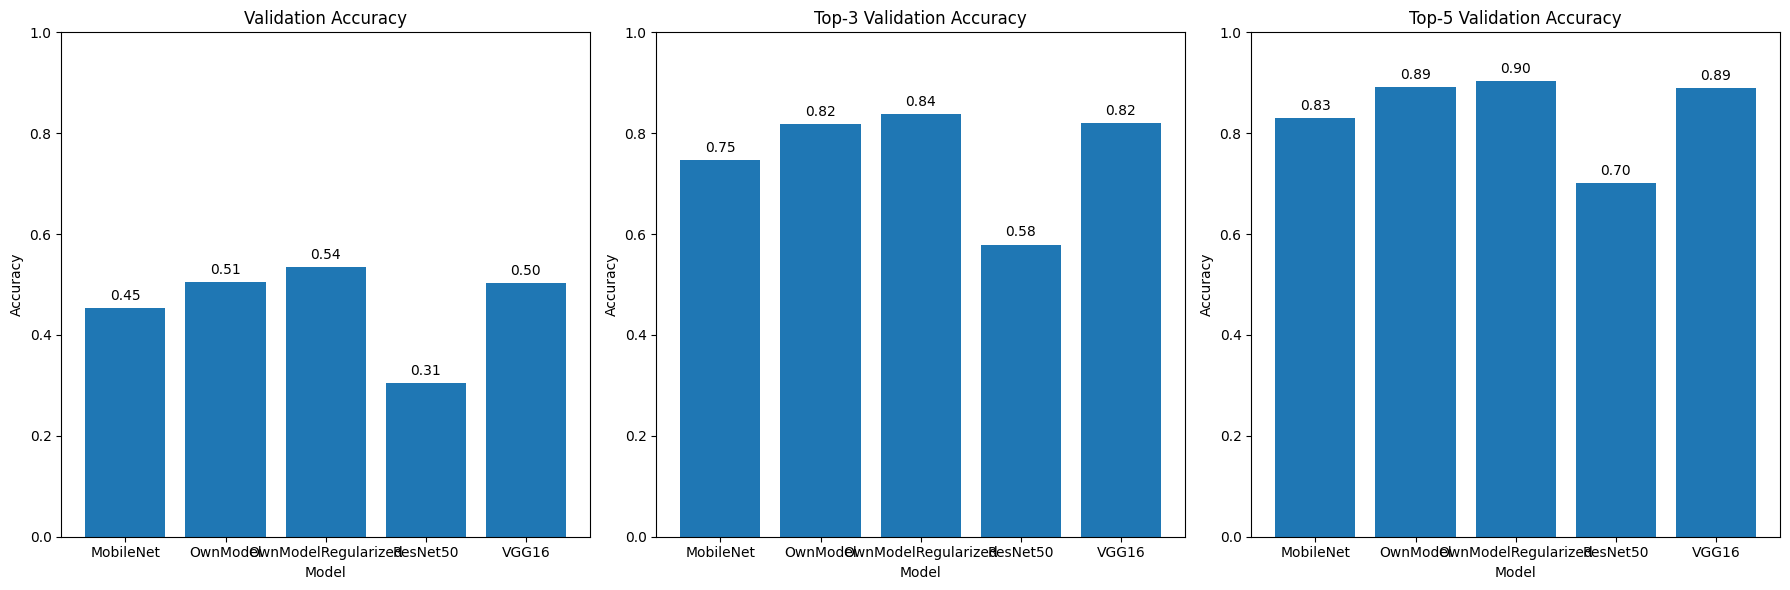

In [5]:
# Function to create bar plots for each Top-k accuracy
def create_bar_plot(y_values, title, y_label, ax):
    ax.bar(top_results['Model'], y_values)
    ax.set_title(title)
    ax.set_ylim([0, 1])
    ax.set_xlabel('Model')
    ax.set_ylabel(y_label)
    for i, v in enumerate(y_values):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy plot
create_bar_plot(top_results['Accuracy'], 'Validation Accuracy', 'Accuracy', axs[0])

# Top-3 Accuracy plot
create_bar_plot(top_results['Top-3 Accuracy'], 'Top-3 Validation Accuracy', 'Accuracy', axs[1])

# Top-5 Accuracy plot
create_bar_plot(top_results['Top-5 Accuracy'], 'Top-5 Validation Accuracy', 'Accuracy', axs[2])

plt.tight_layout()
plt.show()

### Compare the models for the different metrics over the epochs

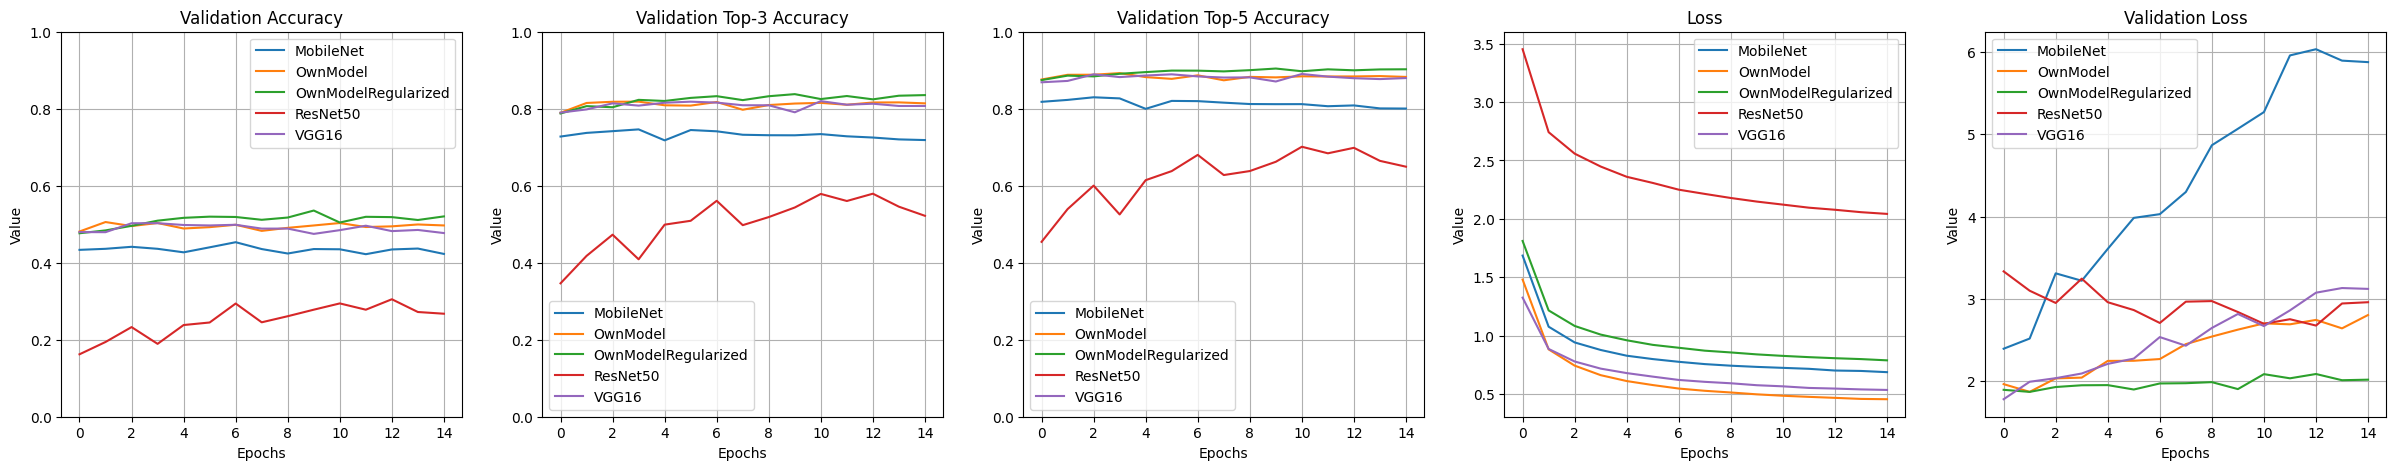

In [6]:
def plot_combined_metrics(histories, titles):
    fig, axs = plt.subplots(1, 5, figsize=(30, 5))
    
    # Iterate over each metric and plot for all models
    for i, metric in enumerate(['val_accuracy', 'val_top_3_accuracy', 'val_top_5_accuracy', 'loss', 'val_loss']):
        for model_name, history in histories.items():
            # For accuracy metrics, plot validation only
            axs[i].plot(history[f'{metric}'], label=f'{model_name}')
        
        axs[i].set_title(f'{titles[i]}')
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel('Value')
        if 'accuracy' in metric:
            axs[i].set_ylim([0, 1])
        axs[i].legend()
        axs[i].grid()

plot_combined_metrics(results, ['Validation Accuracy', 'Validation Top-3 Accuracy', 'Validation Top-5 Accuracy', 'Loss', 'Validation Loss'])

### Evaluate by running model, obsolete?

In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, cmap=plt.cm.Blues, figsize=(10,  10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=12)  # Increase font size
    plt.yticks(tick_marks, classes, size=12)  # Increase font size

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() /  2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]),  # Cast to int to avoid decimal points
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size=12)  # Increase font size

    plt.tight_layout()
    plt.ylabel('True label', size=14)  # Increase font size
    plt.xlabel('Predicted label', size=14)  # Increase font size
    plt.show()

# Function to load a model
def load_model(model_path):
    return keras.models.load_model(model_path)

In [8]:
# Configuration
dataset = 'gempundit_2022_cropped_augmented_2000'
data_dir = "../dat/" + dataset
model_dir = "../mod/"  + dataset
target_size = (224, 224)
batch_size = 32

validation_split = 0.2  # Percentage of data to use for validation

datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation' 
)

# Evaluation
model_paths = [os.path.join(model_dir, file) for file in os.listdir(model_dir) if file.endswith('.h5')]

for model_path in model_paths:
    model_name = os.path.splitext(os.path.basename(model_path))[0] 
    model = load_model(model_path)

    print(f"\nEvaluating model: {model_name}")

    # Predictions
    y_pred = model.predict(val_data)
    y_pred_single = np.argmax(y_pred, axis=1)
    y_true = val_data.classes

    labels =list(val_data.class_indices.values())

    # Metrics
    accuracy = accuracy_score(y_true, y_pred_single)
    top_3_accuracy = top_k_accuracy_score(y_true, y_pred, k=3, labels=labels)
    top_5_accuracy = top_k_accuracy_score(y_true, y_pred, k=5, labels=labels)
    # Macro-Averaged F1 Score
    f1_score = 0# f1_score(y_true, y_pred_single, average='macro')

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Top-3 Accuracy: {top_3_accuracy:.3f}")
    print(f"Top-5 Accuracy: {top_5_accuracy:.3f}")
    print(f"F1 Score: {f1_score:.3f}")

    # Confusion Matrix
    #cm = confusion_matrix(y_true, y_pred_single)
    #plot_confusion_matrix(cm, classes=val_data.class_indices, title=f'Confusion Matrix - {model_name}')
    #plt.show()

Found 41150 images belonging to 99 classes.

Evaluating model: MobileNet
1286/1286 [==============================] - 42s 31ms/step
Accuracy: 0.011
Top-3 Accuracy: 0.031
Top-5 Accuracy: 0.051
F1 Score: 0.000

Evaluating model: OwnModel
1286/1286 [==============================] - 40s 30ms/step
Accuracy: 0.010
Top-3 Accuracy: 0.030
Top-5 Accuracy: 0.051
F1 Score: 0.000

Evaluating model: OwnModelRegularized
1286/1286 [==============================] - 41s 32ms/step
Accuracy: 0.010
Top-3 Accuracy: 0.030
Top-5 Accuracy: 0.050
F1 Score: 0.000

Evaluating model: ResNet50
1286/1286 [==============================] - 114s 88ms/step
Accuracy: 0.010
Top-3 Accuracy: 0.030
Top-5 Accuracy: 0.050
F1 Score: 0.000

Evaluating model: VGG16
1286/1286 [==============================] - 109s 82ms/step
Accuracy: 0.009
Top-3 Accuracy: 0.029
Top-5 Accuracy: 0.049
F1 Score: 0.000
